A/B тест проводиться інтернет-магазином для перевірки ефективності нової веб-сторінки, метою якої є збільшення кількості користувачів, які здійснюють покупку. Завдання полягає в аналізі результатів тесту, щоб зрозуміти, чи варто впроваджувати нову сторінку або залишити стару, 

План дій:
- Огляд даних
- Предобробка даних
- Аналіз даних
- Аналіз A/B тесту
- Висновки

Доступні дані:
- user_id: унікальний ідентифікатор користувача
- timestamp час перебування на сайті
- group група, до якої належить користувач (контрольна або тестова група)
- landing_page тип сторінки, яку побачив користувач (нова або стара сторінка)
- converted індикатор, що показує, чи здійснив користувач покупку (1 — здійснив покупку, 0 — не здійснив)

In [357]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

In [234]:
!ls

Untitled.ipynb	ab_data.csv  countries.csv


In [235]:
ab = pd.read_csv('ab_data.csv')
country = pd.read_csv('countries.csv')

# Огляд даних

In [236]:
ab.shape, country.shape

((294480, 5), (290586, 2))

In [237]:
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [238]:
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [239]:
df = ab.merge(country, on='user_id', how='left', suffixes=('', '_r'))

In [240]:
df.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294482 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294482 non-null  int64 
 1   timestamp     294482 non-null  object
 2   group         294482 non-null  object
 3   landing_page  294482 non-null  object
 4   converted     294482 non-null  int64 
 5   country       294482 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


In [242]:
ab['user_id'].duplicated().sum(), country['user_id'].duplicated().sum()

(3895, 1)

In [243]:
country.shape[0] + ab['user_id'].duplicated().sum()

294481

In [244]:
df.shape

(294482, 6)

# Предобробка даних

In [245]:
def timestamp(x):
    minn, sec = x.split('.')[0].split(':')
    minn, sec = x.split(':')
    return int(minn) * 60 + round(float(sec))

In [246]:
df['timestamp_s'] = df['timestamp'].apply(lambda x: timestamp(x))

In [247]:
df.head()

,user_id,timestamp,group,landing_page,converted,country,timestamp_s
0,851104,11:48.6,control,old_page,0,US,709
1,804228,01:45.2,control,old_page,0,US,105
2,661590,55:06.2,treatment,new_page,0,US,3306
3,853541,28:03.1,treatment,new_page,0,US,1683
4,864975,52:26.2,control,old_page,1,US,3146


In [248]:
nunique = df.groupby('user_id')['group'].nunique()
duplicated = nunique[nunique > 1].sort_values(ascending=False)

In [249]:
df[df['user_id'].isin(duplicated.index)].sort_values(by='user_id').head(20)

,user_id,timestamp,group,landing_page,converted,country,timestamp_s
207211,630320,02:43.6,control,old_page,0,US,164
255754,630320,27:37.2,treatment,old_page,0,US,1657
39852,630805,01:15.1,control,old_page,0,UK,75
73599,630805,45:39.0,treatment,old_page,0,UK,2739
213377,630871,00:05.2,control,old_page,0,US,5
18596,630871,23:01.3,treatment,old_page,0,US,1381
28177,630887,34:14.4,control,new_page,0,US,2054
114320,630887,23:47.4,treatment,new_page,0,US,1427
113635,631008,07:48.1,treatment,old_page,0,US,468
137766,631008,52:17.1,control,old_page,0,US,3137


In [250]:
df.groupby(['group', 'landing_page'])['converted'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145315
           old_page          1965
Name: converted, dtype: int64

**Сталася помилка: контрольна група 1007 разів бачила нову сторінку, а тестова група – 991 раз стару сторінку. Ці дані потрібно видалити.**

In [251]:
control_new_page = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]
treatment_old_page = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]

control_new_page.shape, treatment_old_page.shape

((1928, 7), (1965, 7))

In [252]:
drop_index = np.concatenate([control_new_page.index.values, treatment_old_page.index.values])
df = df.drop(index=drop_index)

In [253]:
df.groupby(['group', 'landing_page'])['converted'].count()

group      landing_page
control    old_page        145274
treatment  new_page        145315
Name: converted, dtype: int64

In [254]:
nunique = df.groupby('user_id')['group'].nunique()
duplicated = nunique[nunique > 1].sort_values(ascending=False)

In [255]:
df[df['user_id'].isin(duplicated.index)].sort_values(by='user_id').head(20)

,user_id,timestamp,group,landing_page,converted,country,timestamp_s


In [267]:
df['user_id'].duplicated(keep=False).sum()

6

In [273]:
df[df.duplicated(keep=False, subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted,country,timestamp_s
1899,773192,37:58.8,treatment,new_page,0,US,2279
2893,773192,55:59.6,treatment,new_page,0,US,3360
250001,759899,07:36.1,treatment,new_page,0,US,456
250002,759899,07:36.1,treatment,new_page,0,US,456
294479,759899,20:29.0,treatment,new_page,0,US,1229
294480,759899,20:29.0,treatment,new_page,0,US,1229


**В одного користувача є два дублікати в датасеті. Потрібно їх видалити.**

In [274]:
df = df.drop(index=[250002, 294480])

In [275]:
df['user_id'].duplicated(keep=False).sum()

4

In [276]:
df[df.duplicated(keep=False, subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted,country,timestamp_s
1899,773192,37:58.8,treatment,new_page,0,US,2279
2893,773192,55:59.6,treatment,new_page,0,US,3360
250001,759899,07:36.1,treatment,new_page,0,US,456
294479,759899,20:29.0,treatment,new_page,0,US,1229


# Аналіз даних

In [277]:
df.head()

,user_id,timestamp,group,landing_page,converted,country,timestamp_s
0,851104,11:48.6,control,old_page,0,US,709
1,804228,01:45.2,control,old_page,0,US,105
2,661590,55:06.2,treatment,new_page,0,US,3306
3,853541,28:03.1,treatment,new_page,0,US,1683
4,864975,52:26.2,control,old_page,1,US,3146


In [278]:
df.apply(lambda x: x.nunique())

user_id         290585
timestamp        35991
group                2
landing_page         2
converted            2
country              3
timestamp_s       3601
dtype: int64

In [280]:
df['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [ ]:
group, counry

timestamp, converted

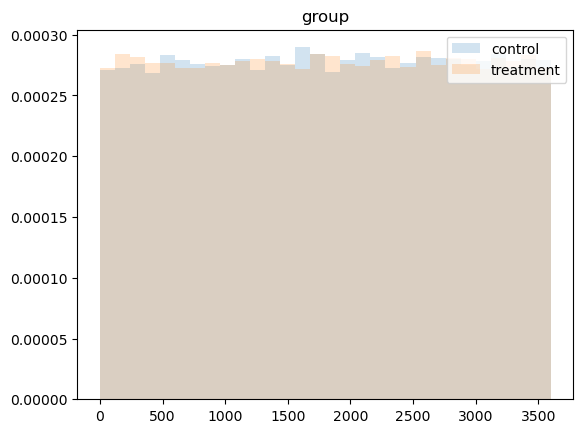

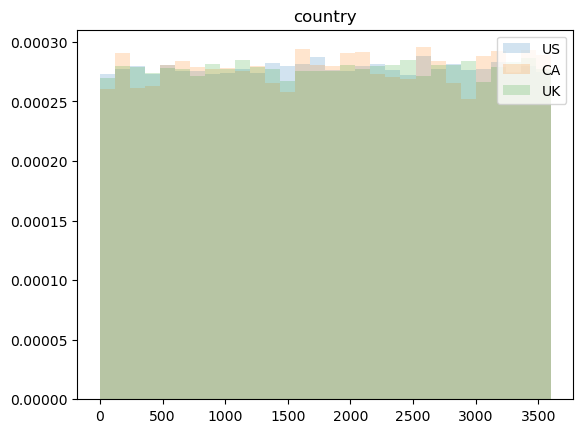

In [283]:
for i in ['group', 'country']:
    for c in df[i].unique():
        plt.hist(df[df[i] == c]['timestamp_s'], bins=30, alpha=0.2, label=c, density=True)
    plt.title(i)
    plt.legend()
    plt.show();

control country
CA    1808.720895
UK    1807.494719
US    1803.739117
Name: timestamp_s, dtype: float64


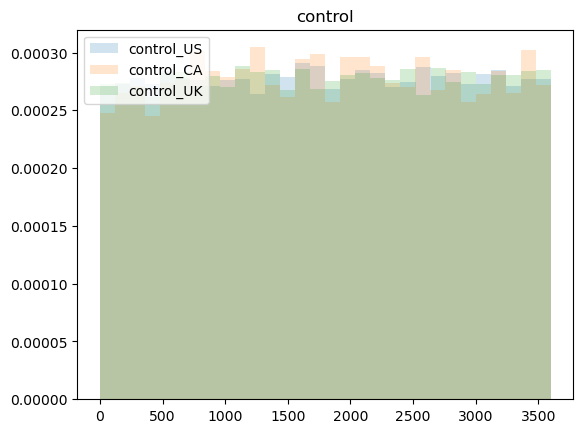

treatment country
CA    1813.189563
UK    1800.402759
US    1801.083724
Name: timestamp_s, dtype: float64


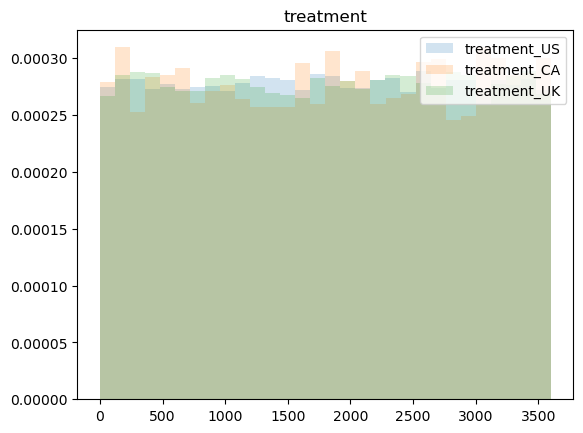

In [291]:
for i in ['control', 'treatment']:
    for c in df['country'].unique():
        plt.hist(df[(df['group'] == i) & (df['country'] == c)]['timestamp_s'], bins=30, alpha=0.2, label=f'{i}_{c}', density=True)

    print(i, df[df['group'] == i].groupby('country')['timestamp_s'].mean())
    
    plt.title(i)
    plt.legend()
    plt.show();

US group
control      1803.739117
treatment    1801.083724
Name: timestamp_s, dtype: float64


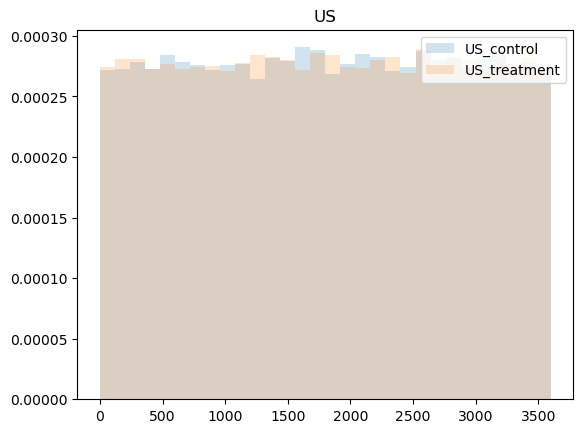

CA group
control      1808.720895
treatment    1813.189563
Name: timestamp_s, dtype: float64


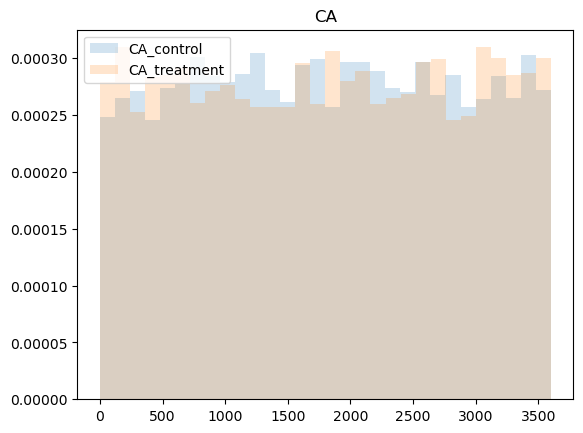

UK group
control      1807.494719
treatment    1800.402759
Name: timestamp_s, dtype: float64


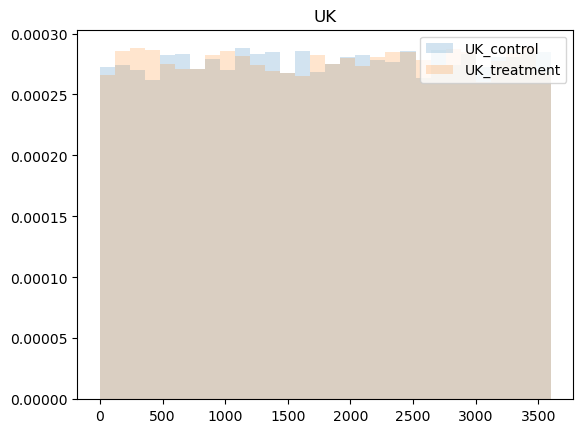

In [290]:
for i in ['US', 'CA', 'UK']:
    for c in df['group'].unique():
        plt.hist(df[(df['country'] == i) & (df['group'] == c)]['timestamp_s'], bins=30, alpha=0.2, label=f'{i}_{c}', density=True)

    print(i, df[df['country'] == i].groupby('group')['timestamp_s'].mean())
    
    plt.title(i)
    plt.legend()
    plt.show();

In [292]:
df['country'].value_counts(normalize=True)

country
US    0.700726
UK    0.249378
CA    0.049896
Name: proportion, dtype: float64

In [299]:
for i in ['group', 'country']:
    print(i, df.groupby(i)['converted'].mean(), '\n')

group group
control      0.120386
treatment    0.118806
Name: converted, dtype: float64 

country country
CA    0.115318
UK    0.120594
US    0.119545
Name: converted, dtype: float64 



In [301]:
pt = pd.pivot_table(data=df, values='converted', index='group', columns='country', aggfunc='mean')
pt

country,CA,UK,US
group,,,
control,0.118783,0.120022,0.120630
treatment,0.111902,0.121171,0.118462


<Axes: xlabel='country', ylabel='group'>

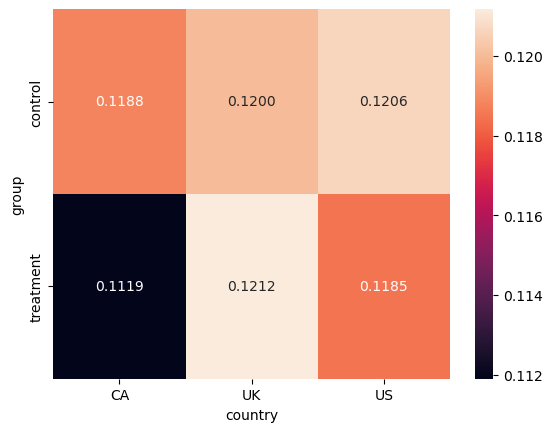

In [306]:
sns.heatmap(pt, annot=True, fmt='.4f')

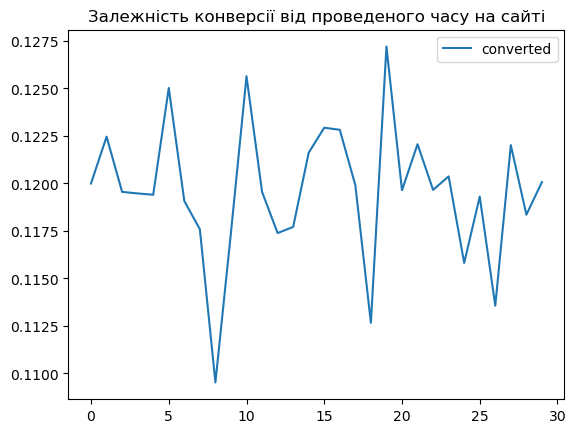

In [358]:
df['timestamp_bins'] = pd.qcut(df['timestamp_s'], 30)

df.groupby('timestamp_bins')['converted'].mean().reset_index().plot()
plt.title('Залежність конверсії від проведеного часу на сайті')
plt.show();

In [329]:
q95 = np.quantile(df['timestamp_s'], 0.95)
print(f'95 квантиль {q95} секунд')

95 квантиль 3419.0 секунд


In [331]:
new_df = df[df['timestamp_s'] > q95]
new_df.shape

(14525, 7)

In [332]:
pt = pd.pivot_table(data=new_df, values='converted', index='group', columns='country', aggfunc='mean')
pt

country,CA,UK,US
group,,,
control,0.127479,0.131068,0.118597
treatment,0.114504,0.118982,0.117414


<Axes: xlabel='country', ylabel='group'>

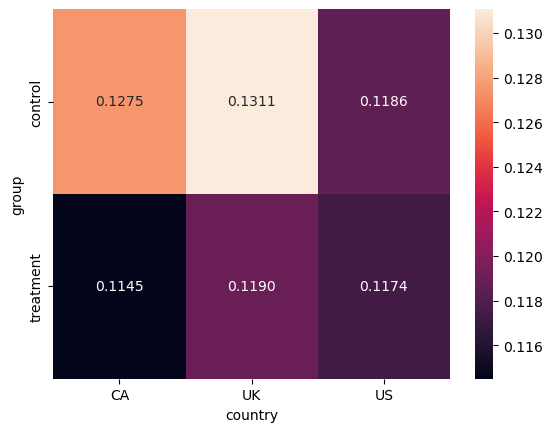

In [333]:
sns.heatmap(pt, annot=True, fmt='.4f')

**У розрізі груп та країн відмінностей у проведеному на сайті часі та конверсії не виявлено.**

**Залежності конверсії від часу, проведеного на сайті, не знайдено.**

**Топ 5% користувачів перебувають на сайті 3419 секунд (56 хвилин) і більше. Їхній рівень конверсії такий самий, як у інших користувачів.**

# Аналіз A/Б тесту

На сайті проводиться A/B тест для перевірки, чи збільшить нова веб-сторінка рівень конверсії. Сформулюємо гіпотези:

- H0: Нова сторінка в тестовій групі генерує такий самий рівень конверсії, як стара сторінка в контрольній групі.
- H1: Нова сторінка в тестовій групі генерує вищий рівень конверсії, ніж стара сторінка в контрольній групі.

In [361]:
alpha = 0.05

conversions = df.groupby('group')['converted'].sum().values
n = df.groupby('group')['converted'].count().values

_, pval = proportions_ztest(conversions, n)
pval = round(pval, 3)

if pval > alpha:
    print(f'pval = {pval}. Не відхиляємо H0. Рівень конверсії в контрольній і тестовій групах однаковий.')
else:
    print(f'pval = {pval}. Відхиляємо H0. Рівень конверсії в тестовій групі вищий, ніж у контрольній.')

pval = 0.189. Не відхиляємо H0. Рівень конверсії в контрольній і тестовій групах однаковий.


# Висновки

Після аналізу даних, були виявлені деякі технічні помилки, зокрема некоректний розподіл користувачів між групами та дублікати записів, які потребують видалення для коректного аналізу.

У ході тесту не було виявлено суттєвих відмінностей між контрольними і тестовими групами ні за часом, проведеним на сайті, ні за рівнем конверсії. Більше того, не спостерігалася залежність між часом на сайті і ймовірністю конверсії, і навіть топ 5% користувачів, що перебували на сайті найдовше, не показали кращих результатів за конверсією порівняно з іншими.

В результаті статистичного тестування, p-value склало 0.189. Це означає, що ми не можемо відхилити нульову гіпотезу, і, відповідно, немає достатніх доказів на користь того, що нова сторінка генерує вищий рівень конверсії, ніж стара.